# Summer School - Modeling Water Fluxes In The Soil-Plant System

## Coupled soil root hydraulics - the alpha and omega of RWU (Vanderborght et al. 2024)


In [14]:
import os, sys
sourcedir = os.getcwd()+"/../../../../"
sourcedir2 = os.getcwd()+"/../../.."
sys.path.append(sourcedir2); sys.path.append(sourcedir2+"/src")
sys.path.append(sourcedir); sys.path.append(sourcedir2+"/src")
sys.path.append(sourcedir+"dumux-rosi/python/modules");
sys.path.append(sourcedir+"dumux-rosi/python/modules/fv/");
sys.path.append(sourcedir+"dumux-rosi/build-cmake/cpp/python_binding/"); 

import plantbox as pb
import visualisation.vtk_plot as vp
from functional.PlantHydraulicParameters import PlantHydraulicParameters
from functional.PlantHydraulicModel import HydraulicModel_Doussan
from functional.PlantHydraulicModel import HydraulicModel_Meunier
from functional.Perirhizal import PerirhizalPython as Perirhizal
import functional.van_genuchten as vg

from rosi_richards import RichardsSP  # C++ part (Dumux binding)
from richards import RichardsWrapper  # Python part
import numpy as np
import matplotlib.pyplot as plt
import figure_style
import timeit

In [15]:
def sinusoidal(t):
    return np.sin(2. * np.pi * np.array(t) - 0.5 * np.pi) + 1.


def make_source(q, area):
    s = {}
    for i in range(0, len(q)):
        if not np.isnan(q[i]):
            s[i] = -q[i] * area

    return s


""" Parameters """  # |\label{l7xa:param}|
depth = -100
N = 100
min_b = [-10., -10., depth]  # [cm]
max_b = [10., 10., 0.]  # [cm]
cell_number = [1, 1, N]  # [cm3]

kx = 10 * 4.32e-2  # axial conductivity [cm3/day]
kr = 1.728e-4  # radial conductivity [1/day]

path = "../../../modelparameter/structural/rootsystem/"
name = "Zeamays_synMRI_modified"  #"Anagallis_femina_Leitner_2010"  # Zea_mays_1_Leitner_2010, Zeamays_synMRI.xml  <<<<-------
trans = 1.5 * 400  # cm3 /day (sinusoidal) = mL/day
wilting_point = -15000  # cm
rs_age = 60  # root system initial age [day]

loam = [0.01, 0.43, 0.0083, 1.2539, 2.272]  # jan paper
sp = vg.Parameters(loam)  # needed for Perirhizal class
vg.create_mfp_lookup(sp, wilting_point = -16000, n = 1501)  # needed for Perirhizal class
initial = -500  # cm (-330 )

sim_time = 7  # [day]
dt = 3600. / (24 * 3600)  # [days]  # |\label{l7xa:param_end}|


initializing look up tables
done


In [10]:

""" Initialize macroscopic soil model """
s = RichardsWrapper(RichardsSP())  
s.initialize()
s.createGrid(min_b, max_b, cell_number, periodic = True)  # [cm]
s.setHomogeneousIC(initial, False)  # [cm] False = matrix, True, = total potential
s.setTopBC("noFlux")
s.setBotBC("noFlux")
s.setVGParameters([loam])
s.setParameter("Soil.SourceSlope", "100") 
s.initializeProblem()
s.setCriticalPressure(wilting_point)  

""" Initialize xylem model """
plant = pb.MappedPlant() 
plant.enableExtraNode()
plant.readParameters(path + name + ".xml")
sdf = pb.SDF_PlantBox(np.inf, np.inf, max_b[2] - min_b[2] - 0.5)  
plant.setGeometry(sdf)  
plant.setRectangularGrid(pb.Vector3d(min_b), pb.Vector3d(max_b), pb.Vector3d(cell_number), False, False)  # needed for Perirhizal class

""" root hydraulic properties """
params = PlantHydraulicParameters()  
params.read_parameters("../../../modelparameter/functional/plant_hydraulics/couvreur2012")
# params.set_kr_const(kr)
# params.set_kx_const(kx)
# params.plot_conductivities(True) 
hm = HydraulicModel_Doussan(plant, params)
hm.wilting_point = wilting_point  

""" Coupling (map indices) """
picker = lambda x, y, z: s.pick([0, 0, z]) 
plant.setSoilGrid(picker)
plant.initialize(True)
plant.simulate(rs_age, True)
hm.test() 

peri = Perirhizal(plant)
h_bs = s.getSolutionHead()
h_sr = np.ones(h_bs.shape) * wilting_point


No parameter file found. Continuing without parameter file.
Computed bounding box tree with 199 nodes for 100 grid entities in 4.4544e-05 seconds.
Computed bounding box tree with 199 nodes for 100 grid entities in 6.6835e-05 seconds.
MappedPlant::initializeLB 
Seed::initialize: RootSystem 
Seed::initialize: Shoot borne definition is DEPRICATED, shoot borne roots will be handeled like basal roots 
Organism::simulate: from 0 to 60 days
nodes moved 0
new nodes added 54110
segments added 54110
Number of segments 54111, including 54110 new 
PlantHydraulicModel.test():
54112 nodes:
Node 0 [ 0.1  0.  -3. ]
Node 1 [ 0.  0. -3.]
Node 2 [ 8.62376833e-03  1.70082247e-03 -3.49992273e+00]
Node 3 [ 0.04311898 -0.02420353 -3.9980583 ]
Node 4 [ 0.06471803 -0.04545196 -4.37347763]
54111 segments:
Segment 0 [0 1] subType 0
Segment 1 [1 2] subType 1
Segment 2 [2 3] subType 1
Segment 3 [3 4] subType 1
Segment 4 [4 5] subType 2
Collar segment index 0
Collar segment [0 1]
0 segments with length < 1.e-5 cm
6

In [17]:
""" Numerical solution """
start_time = timeit.default_timer()
t = 0.
x_, y_ = [], []
N = round(sim_time / dt)
area = (plant.maxBound.x - plant.minBound.x) * (plant.maxBound.y - plant.minBound.y)  # [cm2]

for i in range(0, N): 

    h_bs = s.getSolutionHead()
    h_bs = np.array(plant.matric2total(h_bs))

    start_time_ao = timeit.default_timer()

    hm.update(rs_age + sim_time)

    # Alpha: root system averaged stress factor
    # krs, _ = hm.get_krs(rs_age + sim_time)  # [cm2/day] (could be precomputed for static case)
    krs = hm.krs
    krs = krs / area
    print("krs", krs)

    k_srs = hm.get_soil_rootsystem_conductance(rs_age + sim_time, h_bs, wilting_point, sp)
    h_bs_diff = h_bs - np.ones(h_bs.shape) * wilting_point
    alpha = np.multiply(k_srs, h_bs_diff) / (-krs * wilting_point)  # [1]
    # print(alpha)
    # print("alpha", np.nanmin(alpha), np.nanmax(alpha))

    # Omega: root system averaged stress factor
    # suf_ = hm.get_suf(rs_age + sim_time)
    suf_ = hm.suf
    suf = peri.aggregate(suf_[0,:])
    # print(suf)
    # print("suf", np.min(suf), np.max(suf), np.sum(suf))
    alphaSUF = np.multiply(alpha, suf)
    omega = np.nansum(alphaSUF)  # note that nan are treated as 0
    print("omega", omega)
    # print("alphaSUF", np.nanmin(alphaSUF), np.nanmax(alphaSUF))

    # Omega_c: critical stress factor
    tp = trans * sinusoidal(t) / area  # potential tranpiration [cm3 day-1] -> [cm day-1]
    # print("tp", tp)
    omega_c = tp / (-wilting_point * krs)
    print("max uptake", (-wilting_point * krs), tp)
    print("omega_c", omega_c)
    print("omega / omega_c", omega / omega_c)

    # Sink, stressed
    q_s = alphaSUF * tp / omega_c
    # print("q_s", np.nansum(q_s), np.nanmin(q_s), np.nanmax(q_s))

    # Sink, unstressed
    denumerator = np.multiply(h_bs_diff, np.nansum(np.divide(alphaSUF, h_bs_diff)))
    print("denumerator", np.nansum(denumerator), np.nanmin(denumerator), np.nanmax(denumerator))
    print("- term: ", np.nansum(np.divide(alphaSUF, denumerator) * (omega / omega_c - 1) * tp))
    q_us = alphaSUF * tp / omega_c - np.divide(alphaSUF, denumerator) * (omega / omega_c - 1) * tp
    # print("q_us", np.nansum(q_us), np.nanmin(q_us), np.nanmax(q_us))

    print("pot", tp, "q_us", np.nansum(q_us), "q_s", np.nansum(q_s))

    if omega < omega_c:
        print("stressed")
        q = q_s
    else:
        print("unstressed")
        q = q_us

    start_time_soil = timeit.default_timer()

    fluxes = make_source(q, area)
    s.setSource(fluxes)
    s.solve(dt) 

    final_time = timeit.default_timer()

    x_.append(t)
    y_.append(-np.nansum(q) * area) 

    n = round(float(i) / float(N) * 100.)  
    print("[" + ''.join(["*"]) * n + ''.join([" "]) * (100 - n) + "], potential {:g}, actual {:g}; [{:g}, {:g}] cm soil at {:g} days"
            .format(tp * area, np.nansum(q) * area, np.min(h_bs), np.max(h_bs), s.simTime))

    print("wall times:", (start_time_ao - start_time_soil) / (start_time_ao - final_time), (start_time_soil - final_time) / (start_time_ao - final_time))

#    if i % 10 == 0: 
#        vp.write_soil("results/example72_{:06d}".format(i // 10), s, min_b, max_b, cell_number)
#        vp.write_plant("results/example72_{:06d}".format(i // 10), hm.ms.plant())  

    t += dt  # [day]

print ("Coupled benchmark solved in ", timeit.default_timer() - start_time, " s")  # |\label{l7xa:timing}|


krs 0.00021977839498861805
omega 0.3745912441672009
max uptake 3.2966759248292705 0.0
omega_c 0.0
omega / omega_c inf
denumerator 39.60804684531085 0.274922118082768 0.48958598816433624
- term:  0.0
pot 0.0 q_us 0.0 q_s 0.0
unstressed
[                                                                                                    ], potential 0, actual 0; [-6904.11, -582.706] cm soil at 7.04167 days
wall times: 0.9907846866819017 0.009215313318098344


/tmp/ipykernel_9068/3143568817.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  print("omega / omega_c", omega / omega_c)
/tmp/ipykernel_9068/3143568817.py:49: RuntimeWarning: invalid value encountered in divide
  q_s = alphaSUF * tp / omega_c
/tmp/ipykernel_9068/3143568817.py:55: RuntimeWarning: divide by zero encountered in scalar divide
  print("- term: ", np.nansum(np.divide(alphaSUF, denumerator) * (omega / omega_c - 1) * tp))
/tmp/ipykernel_9068/3143568817.py:55: RuntimeWarning: invalid value encountered in multiply
  print("- term: ", np.nansum(np.divide(alphaSUF, denumerator) * (omega / omega_c - 1) * tp))
/tmp/ipykernel_9068/3143568817.py:56: RuntimeWarning: invalid value encountered in divide
  q_us = alphaSUF * tp / omega_c - np.divide(alphaSUF, denumerator) * (omega / omega_c - 1) * tp
/tmp/ipykernel_9068/3143568817.py:56: RuntimeWarning: divide by zero encountered in scalar divide
  q_us = alphaSUF * tp / omega_c - np.divide(alphaSUF, denumerator) * (om

krs 0.00021977839498861805
omega 0.37483588990128264
max uptake 3.2966759248292705 0.05111126056639753
omega_c 0.015503877764097937
omega / omega_c 24.176912099325477
denumerator 39.62853413668196 0.2753069952155074 0.48976779541535836
- term:  1.1846011934331162
pot 0.05111126056639753 q_us 0.05111126056639724 q_s 1.235712453999513
unstressed
[*                                                                                                   ], potential 20.4445, actual 20.4445; [-6896.33, -583.672] cm soil at 7.08333 days
wall times: 0.990318388755846 0.009681611244154021
krs 0.00021977839498861805
omega 0.37506317566289654
max uptake 3.2966759248292705 0.2009618943233419
omega_c 0.06095894740813791
omega / omega_c 6.152717387846928
denumerator 39.6494929756279 0.2768162412367692 0.48993593429077276
- term:  1.0354998471745411
pot 0.2009618943233419 q_us 0.2009618943233418 q_s 1.2364617414978827
unstressed
[*                                                                            

2025-08-28 15:46:13.216 (2241.861s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error opening output file "results/example72_000001.vtu"
2025-08-28 15:46:13.216 (2241.861s) [         AC51080]       vtkXMLWriter.cxx:651    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error code "No such file or directory"
2025-08-28 15:46:13.216 (2241.861s) [         AC51080]       vtkExecutive.cxx:752    ERR| vtkCompositeDataPipeline (0x2e3d19a0): Algorithm vtkXMLImageDataWriter(0x2bf168c0) returned failure for request: vtkInformation (0x2eba2740)
  Debug: Off
  Modified Time: 13653892
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: -1
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2025-08-28 15:46:14.057 (2242.702s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLPolyDataWriter (0x2dea92b0): Error opening output file "results/example72_000001.vtp"
2025-08-28 15:46:14.058 (2242.703s) [         AC51

krs 0.00021977839498861805
omega 0.3395139052596481
max uptake 3.2966759248292705 2.9488887394336025
omega_c 0.8945036778482619
omega / omega_c 0.379555628073383
denumerator 36.143197285815155 0.2393838282860978 0.4585647965472594
- term:  -1.8296214218193547
pot 2.9488887394336025 q_us 2.948888739433602 q_s 1.1192673176142476
stressed
[*******                                                                                             ], potential 1179.56, actual 447.707; [-7479.41, -593.522] cm soil at 7.5 days
wall times: 0.9911228522307911 0.008877147769208858
krs 0.00021977839498861805
omega 0.3346776354705879
max uptake 3.2966759248292705 3.0
omega_c 0.9100075556123598
omega / omega_c 0.36777456781155793
denumerator 35.66532057366094 0.23406198333739975 0.454274649834221
- term:  -1.8966762965653254
pot 3.0 q_us 2.9999999999999996 q_s 1.1033237034346737
stressed
[*******                                                                                             ], potential 1200, 

2025-08-28 15:46:17.636 (2246.281s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error opening output file "results/example72_000002.vtu"
2025-08-28 15:46:17.636 (2246.281s) [         AC51080]       vtkXMLWriter.cxx:651    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error code "No such file or directory"
2025-08-28 15:46:17.636 (2246.281s) [         AC51080]       vtkExecutive.cxx:752    ERR| vtkCompositeDataPipeline (0x2e3d19a0): Algorithm vtkXMLImageDataWriter(0x2bf168c0) returned failure for request: vtkInformation (0x2e6828c0)
  Debug: Off
  Modified Time: 14412425
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: -1
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2025-08-28 15:46:18.497 (2247.142s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLPolyDataWriter (0x2e300480): Error opening output file "results/example72_000002.vtp"
2025-08-28 15:46:18.497 (2247.142s) [         AC51

krs 0.00021977839498861805
omega 0.2958380985257713
max uptake 3.2966759248292705 0.4393398282201808
omega_c 0.13326752105393358
omega / omega_c 2.2198814548823576
denumerator 31.817971006144976 0.19276636692811633 0.4195353230322127
- term:  0.5359425088369991
pot 0.4393398282201808 q_us 0.43933982822018086 q_s 0.97528233705718
unstressed
[************                                                                                        ], potential 175.736, actual 175.736; [-8385.23, -603.653] cm soil at 7.91667 days
wall times: 0.9901333826385728 0.009866617361427233
krs 0.00021977839498861805
omega 0.2942439112637137
max uptake 3.2966759248292705 0.20096189432334377
omega_c 0.060958947408138474
omega / omega_c 4.826919160753585
denumerator 31.659461156498775 0.19188072465882364 0.418083089162328
- term:  0.7690649239673413
pot 0.20096189432334377 q_us 0.20096189432334377 q_s 0.9700268182906852
unstressed
[*************                                                               

2025-08-28 15:46:22.097 (2250.742s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error opening output file "results/example72_000003.vtu"
2025-08-28 15:46:22.098 (2250.743s) [         AC51080]       vtkXMLWriter.cxx:651    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error code "No such file or directory"
2025-08-28 15:46:22.098 (2250.743s) [         AC51080]       vtkExecutive.cxx:752    ERR| vtkCompositeDataPipeline (0x2d795740): Algorithm vtkXMLImageDataWriter(0x2bf168c0) returned failure for request: vtkInformation (0x2deab410)
  Debug: Off
  Modified Time: 15170958
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: -1
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2025-08-28 15:46:22.963 (2251.608s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLPolyDataWriter (0x2dce96b0): Error opening output file "results/example72_000003.vtp"
2025-08-28 15:46:22.963 (2251.608s) [         AC51

krs 0.00021977839498861805
omega 0.28117073864017983
max uptake 3.2966759248292705 1.8882285676537804
omega_c 0.5727674210960146
omega / omega_c 0.4908986235672199
denumerator 30.358241417461215 0.18385532840955912 0.40611873360941025
- term:  -0.9612997628122365
pot 1.8882285676537804 q_us 1.8882285676537804 q_s 0.9269288048415438
stressed
[******************                                                                                  ], potential 755.291, actual 370.772; [-8487.31, -614.105] cm soil at 8.33333 days
wall times: 0.9906019341864515 0.009398065813548512
krs 0.00021977839498861805
omega 0.2772998695326091
max uptake 3.2966759248292705 2.2500000000000013
omega_c 0.6825056667092703
omega / omega_c 0.40629680170953314
denumerator 29.97424375866845 0.17979067360699766 0.4026113676263727
- term:  -1.3358321961535513
pot 2.2500000000000013 q_us 2.2500000000000013 q_s 0.91416780384645
stressed
[*******************                                                              

2025-08-28 15:46:26.711 (2255.356s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error opening output file "results/example72_000004.vtu"
2025-08-28 15:46:26.711 (2255.356s) [         AC51080]       vtkXMLWriter.cxx:651    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error code "No such file or directory"
2025-08-28 15:46:26.711 (2255.356s) [         AC51080]       vtkExecutive.cxx:752    ERR| vtkCompositeDataPipeline (0x2d795740): Algorithm vtkXMLImageDataWriter(0x2bf168c0) returned failure for request: vtkInformation (0x2c4f0520)
  Debug: Off
  Modified Time: 15929491
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: -1
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2025-08-28 15:46:27.569 (2256.214s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLPolyDataWriter (0x2dea92b0): Error opening output file "results/example72_000004.vtp"
2025-08-28 15:46:27.569 (2256.214s) [         AC51

krs 0.00021977839498861805
omega 0.2454693131468042
max uptake 3.2966759248292705 1.8882285676537733
omega_c 0.5727674210960125
omega / omega_c 0.4285671707323877
denumerator 26.809578332138518 0.1472946505686214 0.37355834443754077
- term:  -1.0789957927183271
pot 1.8882285676537733 q_us 1.8882285676537736 q_s 0.8092327749354465
stressed
[************************                                                                            ], potential 755.291, actual 323.693; [-9331.84, -624.811] cm soil at 8.75 days
wall times: 0.9899724491914833 0.010027550808516677
krs 0.00021977839498861805
omega 0.24224259336758236
max uptake 3.2966759248292705 1.4999999999999927
omega_c 0.4550037778061777
omega / omega_c 0.5323968836820796
denumerator 26.488139515984408 0.14409762743896837 0.3705916096892307
- term:  -0.7014046744768772
pot 1.4999999999999927 q_us 1.4999999999999925 q_s 0.7985953255231154
stressed
[*************************                                                          

2025-08-28 15:46:31.196 (2259.841s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error opening output file "results/example72_000005.vtu"
2025-08-28 15:46:31.196 (2259.841s) [         AC51080]       vtkXMLWriter.cxx:651    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error code "No such file or directory"
2025-08-28 15:46:31.196 (2259.841s) [         AC51080]       vtkExecutive.cxx:752    ERR| vtkCompositeDataPipeline (0x2d795740): Algorithm vtkXMLImageDataWriter(0x2bf168c0) returned failure for request: vtkInformation (0x2deab410)
  Debug: Off
  Modified Time: 16688024
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: -1
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2025-08-28 15:46:32.062 (2260.707s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLPolyDataWriter (0x2e300480): Error opening output file "results/example72_000005.vtp"
2025-08-28 15:46:32.062 (2260.707s) [         AC51

krs 0.00021977839498861805
omega 0.23095617752217462
max uptake 3.2966759248292705 0.4393398282201848
omega_c 0.1332675210539348
omega / omega_c 1.7330267397163046
denumerator 25.359713050365915 0.13819085400729256 0.3600458770066972
- term:  0.32204784190776337
pot 0.4393398282201848 q_us 0.4393398282201849 q_s 0.7613876701279484
unstressed
[******************************                                                                      ], potential 175.736, actual 175.736; [-9486.8, -635.765] cm soil at 9.16667 days
wall times: 0.989862300547676 0.010137699452323972
krs 0.00021977839498861805
omega 0.22938013938465185
max uptake 3.2966759248292705 0.7500000000000047
omega_c 0.22750188890309136
omega / omega_c 1.0082559775244793
denumerator 25.20287530637216 0.13716585207985182 0.35857696648298043
- term:  0.006191983143359485
pot 0.7500000000000047 q_us 0.7500000000000048 q_s 0.7561919831433642
unstressed
[*******************************                                            

2025-08-28 15:46:35.674 (2264.319s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error opening output file "results/example72_000006.vtu"
2025-08-28 15:46:35.674 (2264.319s) [         AC51080]       vtkXMLWriter.cxx:651    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error code "No such file or directory"
2025-08-28 15:46:35.674 (2264.319s) [         AC51080]       vtkExecutive.cxx:752    ERR| vtkCompositeDataPipeline (0x2d795740): Algorithm vtkXMLImageDataWriter(0x2bf168c0) returned failure for request: vtkInformation (0x2cf973b0)
  Debug: Off
  Modified Time: 17446557
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: -1
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2025-08-28 15:46:36.536 (2265.181s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLPolyDataWriter (0x2dce96b0): Error opening output file "results/example72_000006.vtp"
2025-08-28 15:46:36.536 (2265.181s) [         AC51

krs 0.00021977839498861805
omega 0.20445637474649725
max uptake 3.2966759248292705 2.9488887394336043
omega_c 0.8945036778482623
omega / omega_c 0.22856963007499212
denumerator 22.717832928757165 0.11291651853628983 0.3353979018923214
- term:  -2.274862331128956
pot 2.9488887394336043 q_us 2.9488887394336047 q_s 0.6740264083046487
stressed
[************************************                                                                ], potential 1179.56, actual 269.611; [-10167.8, -646.96] cm soil at 9.58333 days
wall times: 0.9898562538632036 0.010143746136796378
krs 0.00021977839498861805
omega 0.20192450404767623
max uptake 3.2966759248292705 2.7990381056766616
omega_c 0.8490486082042229
omega / omega_c 0.23782443324977107
denumerator 22.4649554992921 0.1105273031826279 0.33302803876780046
- term:  -2.133358454549596
pot 2.7990381056766616 q_us 2.7990381056766607 q_s 0.665679651127065
stressed
[*************************************                                              

2025-08-28 15:46:40.153 (2268.798s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error opening output file "results/example72_000007.vtu"
2025-08-28 15:46:40.153 (2268.798s) [         AC51080]       vtkXMLWriter.cxx:651    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error code "No such file or directory"
2025-08-28 15:46:40.153 (2268.798s) [         AC51080]       vtkExecutive.cxx:752    ERR| vtkCompositeDataPipeline (0x2d795740): Algorithm vtkXMLImageDataWriter(0x2bf168c0) returned failure for request: vtkInformation (0x2deab540)
  Debug: Off
  Modified Time: 18205090
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: -1
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2025-08-28 15:46:40.988 (2269.633s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLPolyDataWriter (0x2dea92b0): Error opening output file "results/example72_000007.vtp"
2025-08-28 15:46:40.988 (2269.633s) [         AC51

krs 0.00021977839498861805
omega 0.18341295411036884
max uptake 3.2966759248292705 0.05111126056640186
omega_c 0.015503877764099252
omega / omega_c 11.830134170373784
denumerator 20.614345854348972 0.09474017867457389 0.31558725469216864
- term:  0.5535418095510669
pot 0.05111126056640186 q_us 0.051111260566401744 q_s 0.6046530701174687
unstressed
[******************************************                                                          ], potential 20.4445, actual 20.4445; [-10694.6, -658.344] cm soil at 10 days
wall times: 0.9858329141130335 0.014167085886966461
krs 0.00021977839498861805
omega 0.18354417993208286
max uptake 3.2966759248292705 0.0
omega_c 0.0
omega / omega_c inf
denumerator 20.627701327748085 0.09601398135046386 0.3156867347379073
- term:  0.0
pot 0.0 q_us 0.0 q_s 0.0
unstressed
[*******************************************                                                         ], potential 0, actual 0; [-10638.4, -659.495] cm soil at 10.0417 days
wall time

2025-08-28 15:46:44.585 (2273.230s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error opening output file "results/example72_000008.vtu"
2025-08-28 15:46:44.585 (2273.230s) [         AC51080]       vtkXMLWriter.cxx:651    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error code "No such file or directory"
2025-08-28 15:46:44.585 (2273.230s) [         AC51080]       vtkExecutive.cxx:752    ERR| vtkCompositeDataPipeline (0x2d795740): Algorithm vtkXMLImageDataWriter(0x2bf168c0) returned failure for request: vtkInformation (0x2dce9640)
  Debug: Off
  Modified Time: 18963623
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: -1
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2025-08-28 15:46:45.437 (2274.082s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLPolyDataWriter (0x2e300480): Error opening output file "results/example72_000008.vtp"
2025-08-28 15:46:45.437 (2274.082s) [         AC51

krs 0.00021977839498861805
omega 0.17134439021070344
max uptake 3.2966759248292705 2.560660171779795
omega_c 0.7767400345584189
omega / omega_c 0.22059425623415135
denumerator 19.4053567944266 0.08707890007496041 0.30404872364465046
- term:  -1.9957932457176168
pot 2.560660171779795 q_us 2.560660171779795 q_s 0.5648669260621784
stressed
[************************************************                                                    ], potential 1024.26, actual 225.947; [-10895.9, -669.937] cm soil at 10.4167 days
wall times: 0.9906812552101676 0.009318744789832462
krs 0.00021977839498861805
omega 0.1693573396039207
max uptake 3.2966759248292705 2.7990381056766402
omega_c 0.8490486082042165
omega / omega_c 0.19946718947236788
denumerator 19.206550694558413 0.08528854710753865 0.30215882674737676
- term:  -2.240721841511261
pot 2.7990381056766402 q_us 2.7990381056766407 q_s 0.55831626416538
stressed
[*************************************************                                   

2025-08-28 15:46:49.023 (2277.668s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error opening output file "results/example72_000009.vtu"
2025-08-28 15:46:49.023 (2277.668s) [         AC51080]       vtkXMLWriter.cxx:651    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error code "No such file or directory"
2025-08-28 15:46:49.023 (2277.668s) [         AC51080]       vtkExecutive.cxx:752    ERR| vtkCompositeDataPipeline (0x2d795740): Algorithm vtkXMLImageDataWriter(0x2bf168c0) returned failure for request: vtkInformation (0x2deab760)
  Debug: Off
  Modified Time: 19722156
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: -1
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2025-08-28 15:46:49.868 (2278.513s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLPolyDataWriter (0x2dce96b0): Error opening output file "results/example72_000009.vtp"
2025-08-28 15:46:49.868 (2278.513s) [         AC51

krs 0.00021977839498861805
omega 0.15289508116912967
max uptake 3.2966759248292705 1.1117714323462642
omega_c 0.33724013451635865
omega / omega_c 0.45337154603024604
denumerator 17.55770053843096 0.07090990110712059 0.2864204635755406
- term:  -0.6077258992311773
pot 1.1117714323462642 q_us 1.1117714323462644 q_s 0.5040455331150869
stressed
[******************************************************                                              ], potential 444.709, actual 201.618; [-11455.2, -681.689] cm soil at 10.8333 days
wall times: 0.986613700398891 0.013386299601109026
krs 0.00021977839498861805
omega 0.15121182433043487
max uptake 3.2966759248292705 0.7500000000000387
omega_c 0.2275018889031017
omega / omega_c 0.6646618410928424
denumerator 17.388946366483612 0.06948753967085819 0.2848028463824484
- term:  -0.2515036191803811
pot 0.7500000000000387 q_us 0.7500000000000386 q_s 0.49849638081965764
stressed
[*******************************************************                       

2025-08-28 15:46:53.413 (2282.058s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error opening output file "results/example72_000010.vtu"
2025-08-28 15:46:53.413 (2282.058s) [         AC51080]       vtkXMLWriter.cxx:651    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error code "No such file or directory"
2025-08-28 15:46:53.413 (2282.058s) [         AC51080]       vtkExecutive.cxx:752    ERR| vtkCompositeDataPipeline (0x2d795740): Algorithm vtkXMLImageDataWriter(0x2bf168c0) returned failure for request: vtkInformation (0x2deab410)
  Debug: Off
  Modified Time: 20480689
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: -1
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2025-08-28 15:46:54.266 (2282.911s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLPolyDataWriter (0x2dea92b0): Error opening output file "results/example72_000010.vtp"
2025-08-28 15:46:54.266 (2282.911s) [         AC51

krs 0.00021977839498861805
omega 0.14447590898600207
max uptake 3.2966759248292705 1.111771432346174
omega_c 0.3372401345163313
omega / omega_c 0.4284066283902091
denumerator 16.711619936495207 0.06738934714953262 0.27820824388824
- term:  -0.6354811814741964
pot 1.111771432346174 q_us 1.1117714323461743 q_s 0.4762902508719779
stressed
[************************************************************                                        ], potential 444.709, actual 190.516; [-11534.6, -693.602] cm soil at 11.25 days
wall times: 0.9859057647522351 0.01409423524776493
krs 0.00021977839498861805
omega 0.14291067185747003
max uptake 3.2966759248292705 1.499999999999956
omega_c 0.4550037778061666
omega / omega_c 0.31408678087580744
denumerator 16.55483694343704 0.06604356481092674 0.27669714689881914
- term:  -1.0288698286862585
pot 1.499999999999956 q_us 1.499999999999956 q_s 0.47113017131369733
stressed
[*************************************************************                          

2025-08-28 15:46:57.913 (2286.558s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error opening output file "results/example72_000011.vtu"
2025-08-28 15:46:57.913 (2286.558s) [         AC51080]       vtkXMLWriter.cxx:651    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error code "No such file or directory"
2025-08-28 15:46:57.913 (2286.558s) [         AC51080]       vtkExecutive.cxx:752    ERR| vtkCompositeDataPipeline (0x2d795740): Algorithm vtkXMLImageDataWriter(0x2bf168c0) returned failure for request: vtkInformation (0x2e65cc30)
  Debug: Off
  Modified Time: 21239222
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: -1
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2025-08-28 15:46:58.771 (2287.416s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLPolyDataWriter (0x2e300480): Error opening output file "results/example72_000011.vtp"
2025-08-28 15:46:58.771 (2287.416s) [         AC51

krs 0.00021977839498861805
omega 0.12989242567477777
max uptake 3.2966759248292705 2.560660171779831
omega_c 0.7767400345584298
omega / omega_c 0.16722766935609354
denumerator 15.249738443431106 0.05520653625414886 0.26407556975224467
- term:  -2.1324469392401153
pot 2.560660171779831 q_us 2.560660171779831 q_s 0.4282132325397152
stressed
[******************************************************************                                  ], potential 1024.26, actual 171.285; [-12011.7, -705.659] cm soil at 11.6667 days
wall times: 0.9904008544611934 0.009599145538806567
krs 0.00021977839498861805
omega 0.12855569661977792
max uptake 3.2966759248292705 2.2500000000000098
omega_c 0.6825056667092728
omega / omega_c 0.18835843113158918
denumerator 15.115618679879248 0.05413107725685189 0.2627737497409855
- term:  -1.8261935299539322
pot 2.2500000000000098 q_us 2.2500000000000098 q_s 0.42380647004607747
stressed
[*******************************************************************           

2025-08-28 15:47:02.417 (2291.062s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error opening output file "results/example72_000012.vtu"
2025-08-28 15:47:02.417 (2291.062s) [         AC51080]       vtkXMLWriter.cxx:651    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error code "No such file or directory"
2025-08-28 15:47:02.417 (2291.062s) [         AC51080]       vtkExecutive.cxx:752    ERR| vtkCompositeDataPipeline (0x2d795740): Algorithm vtkXMLImageDataWriter(0x2bf168c0) returned failure for request: vtkInformation (0x2dea60e0)
  Debug: Off
  Modified Time: 21997755
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: -1
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2025-08-28 15:47:03.281 (2291.926s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLPolyDataWriter (0x2dce96b0): Error opening output file "results/example72_000012.vtp"
2025-08-28 15:47:03.281 (2291.926s) [         AC51

krs 0.00021977839498861805
omega 0.12066728804892882
max uptake 3.2966759248292705 0.0511112605663997
omega_c 0.015503877764098594
omega / omega_c 7.783039178001704
denumerator 14.3207821715943 0.04937625004765854 0.2550072325850984
- term:  0.34668968285894275
pot 0.0511112605663997 q_us 0.051111260566399634 q_s 0.3978009434253424
unstressed
[************************************************************************                            ], potential 20.4445, actual 20.4445; [-12234.6, -717.835] cm soil at 12.0833 days
wall times: 0.9905793698082559 0.009420630191744108
krs 0.00021977839498861805
omega 0.12074854844045652
max uptake 3.2966759248292705 0.20096189432334743
omega_c 0.060958947408139584
omega / omega_c 1.9808174775723488
denumerator 14.329124173587752 0.05033963038277673 0.2550655188160581
- term:  0.19710693827838652
pot 0.20096189432334743 q_us 0.20096189432334752 q_s 0.39806883260173404
unstressed
[********************************************************************

2025-08-28 15:47:06.904 (2295.549s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error opening output file "results/example72_000013.vtu"
2025-08-28 15:47:06.904 (2295.549s) [         AC51080]       vtkXMLWriter.cxx:651    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error code "No such file or directory"
2025-08-28 15:47:06.904 (2295.549s) [         AC51080]       vtkExecutive.cxx:752    ERR| vtkCompositeDataPipeline (0x2d795740): Algorithm vtkXMLImageDataWriter(0x2bf168c0) returned failure for request: vtkInformation (0x2dedbf70)
  Debug: Off
  Modified Time: 22756288
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: -1
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2025-08-28 15:47:07.748 (2296.393s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLPolyDataWriter (0x2dea92b0): Error opening output file "results/example72_000013.vtp"
2025-08-28 15:47:07.749 (2296.393s) [         AC51

krs 0.00021977839498861805
omega 0.11111757080329243
max uptake 3.2966759248292705 2.9488887394336105
omega_c 0.8945036778482642
omega / omega_c 0.124222598022835
denumerator 13.363282631651858 0.04322544543605598 0.24559249640924782
- term:  -2.5825701189408843
pot 2.9488887394336105 q_us 2.9488887394336105 q_s 0.36631862049272607
stressed
[******************************************************************************                      ], potential 1179.56, actual 146.527; [-12488.4, -730.136] cm soil at 12.5 days
wall times: 0.9818191007321613 0.01818089926783869
krs 0.00021977839498861805
omega 0.11004739441761067
max uptake 3.2966759248292705 3.0
omega_c 0.9100075556123598
omega / omega_c 0.12093019858890938
denumerator 13.255859761121902 0.042406352548238074 0.2445369362622237
- term:  -2.6372094042332725
pot 3.0 q_us 2.9999999999999996 q_s 0.36279059576672823
stressed
[*******************************************************************************                     ], potent

2025-08-28 15:47:11.398 (2300.043s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error opening output file "results/example72_000014.vtu"
2025-08-28 15:47:11.398 (2300.043s) [         AC51080]       vtkXMLWriter.cxx:651    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error code "No such file or directory"
2025-08-28 15:47:11.398 (2300.043s) [         AC51080]       vtkExecutive.cxx:752    ERR| vtkCompositeDataPipeline (0x2d795740): Algorithm vtkXMLImageDataWriter(0x2bf168c0) returned failure for request: vtkInformation (0x2deab410)
  Debug: Off
  Modified Time: 23514821
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: -1
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2025-08-28 15:47:12.258 (2300.903s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLPolyDataWriter (0x2e300480): Error opening output file "results/example72_000014.vtp"
2025-08-28 15:47:12.258 (2300.903s) [         AC51

krs 0.00021977839498861805
omega 0.10107188870916857
max uptake 3.2966759248292705 0.43933982822013395
omega_c 0.13326752105391937
omega / omega_c 0.7584135122336026
denumerator 12.35454675041351 0.035767571204720794 0.23565275909966205
- term:  -0.1061385660355945
pot 0.43933982822013395 q_us 0.43933982822013395 q_s 0.3332012621845394
stressed
[************************************************************************************                ], potential 175.736, actual 133.281; [-12836, -742.532] cm soil at 12.9167 days
wall times: 0.9901122765909951 0.009887723409004942
krs 0.00021977839498861805
omega 0.1001424845001172
max uptake 3.2966759248292705 0.2009618943233093
omega_c 0.06095894740812802
omega / omega_c 1.6427856575286701
denumerator 12.261168208106245 0.035104469477141076 0.23472909932956174
- term:  0.12917542338081547
pot 0.2009618943233093 q_us 0.20096189432330935 q_s 0.3301373177041248
unstressed
[***********************************************************************

2025-08-28 15:47:15.892 (2304.537s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error opening output file "results/example72_000015.vtu"
2025-08-28 15:47:15.892 (2304.537s) [         AC51080]       vtkXMLWriter.cxx:651    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error code "No such file or directory"
2025-08-28 15:47:15.892 (2304.537s) [         AC51080]       vtkExecutive.cxx:752    ERR| vtkCompositeDataPipeline (0x2d795740): Algorithm vtkXMLImageDataWriter(0x2bf168c0) returned failure for request: vtkInformation (0x2d450b10)
  Debug: Off
  Modified Time: 24273354
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: -1
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2025-08-28 15:47:16.732 (2305.377s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLPolyDataWriter (0x2dce96b0): Error opening output file "results/example72_000015.vtp"
2025-08-28 15:47:16.732 (2305.377s) [         AC51

krs 0.00021977839498861805
omega 0.09584956373254742
max uptake 3.2966759248292705 1.8882285676538637
omega_c 0.57276742109604
omega / omega_c 0.167344650205717
denumerator 11.827440714477023 0.034229544285194716 0.2303725031898995
- term:  -1.5722436184913857
pot 1.8882285676538637 q_us 1.8882285676538635 q_s 0.3159849491624779
stressed
[******************************************************************************************          ], potential 755.291, actual 126.394; [-12883.4, -755.025] cm soil at 13.3333 days
wall times: 0.9904363845945227 0.009563615405477356
krs 0.00021977839498861805
omega 0.09498307631702527
max uptake 3.2966759248292705 2.250000000000076
omega_c 0.6825056667092929
omega / omega_c 0.13916818709357684
denumerator 11.740463610607197 0.033596776107180426 0.22950776065550157
- term:  -1.9368715790395175
pot 2.250000000000076 q_us 2.2500000000000764 q_s 0.31312842096055854
stressed
[*******************************************************************************

2025-08-28 15:47:20.403 (2309.048s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error opening output file "results/example72_000016.vtu"
2025-08-28 15:47:20.403 (2309.048s) [         AC51080]       vtkXMLWriter.cxx:651    ERR| vtkXMLImageDataWriter (0x2bf168c0): Error code "No such file or directory"
2025-08-28 15:47:20.403 (2309.048s) [         AC51080]       vtkExecutive.cxx:752    ERR| vtkCompositeDataPipeline (0x2d795740): Algorithm vtkXMLImageDataWriter(0x2bf168c0) returned failure for request: vtkInformation (0x2d7a1a50)
  Debug: Off
  Modified Time: 25031887
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: -1
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2025-08-28 15:47:21.251 (2309.896s) [         AC51080]       vtkXMLWriter.cxx:649    ERR| vtkXMLPolyDataWriter (0x2dea92b0): Error opening output file "results/example72_000016.vtp"
2025-08-28 15:47:21.251 (2309.896s) [         AC51

krs 0.00021977839498861805
omega 0.0876897272509661
max uptake 3.2966759248292705 1.888228567653667
omega_c 0.5727674210959802
omega / omega_c 0.1530983153391884
denumerator 11.00813851974889 0.028455986541197874 0.22220878601245195
- term:  -1.5991439549705622
pot 1.888228567653667 q_us 1.8882285676536672 q_s 0.28908461268310515
stressed
[************************************************************************************************    ], potential 755.291, actual 115.634; [-13177.4, -767.598] cm soil at 13.75 days
wall times: 0.9834332341629904 0.016566765837009532
krs 0.00021977839498861805
omega 0.08693185375089751
max uptake 3.2966759248292705 1.4999999999998799
omega_c 0.45500377780614343
omega / omega_c 0.1910574329075906
denumerator 10.932018363483094 0.02794130859005786 0.2214481472793468
- term:  -1.2134138506385168
pot 1.4999999999998799 q_us 1.4999999999998799 q_s 0.2865861493613629
stressed
[*********************************************************************************

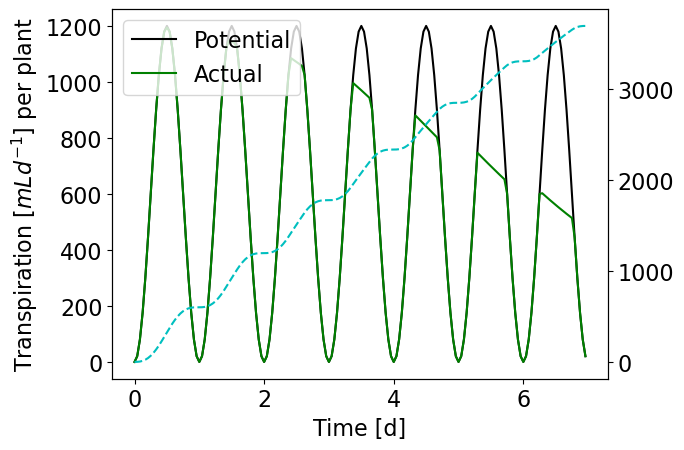

In [16]:
""" VTK visualisation """ 
# vp.plot_roots_and_soil(hm.ms.mappedSegments(), "matric potential", hx, s, True, np.array(min_b), np.array(max_b), cell_number)

""" Transpiration over time """
fig, ax1 = plt.subplots()
ax1.plot(x_, trans * sinusoidal(x_), 'k')  # potential transpiration
ax1.plot(x_, -np.array(y_), 'g')  # actual transpiration
ax2 = ax1.twinx()
ax2.plot(x_, np.cumsum(-np.array(y_) * dt), 'c--')  # cumulative transpiratio
ax1.set_xlabel("Time [d]")
ax1.set_ylabel("Transpiration $[mL d^{-1}]$ per plant")
ax1.legend(['Potential', 'Actual', 'Cumulative'], loc = 'upper left')
plt.show()